In [1]:
%matplotlib inline
import h5py
import pandas as pd
from sklearn import manifold

from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
sns.set()

random_seed = 42

In [2]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,xgboost,tpot -g

CPython 3.6.6
IPython 7.0.1

numpy 1.15.3
pandas 0.23.4
xgboost 0.80
tpot 0.9.5

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 18.0.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : 7c88e45ccc3beb627a9778fd4724c722830db422


In [3]:
mixed_data = pd.read_hdf('ISMS_PALM_data_dump.h5', 'mixed_data')

In [4]:
bad = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'fid_data')
       .assign(good=0).sample(n=300000, random_state=random_seed))
       
good = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'good_data')
        .assign(good=1).sample(n=300000, random_state=random_seed))

df = pd.concat([bad, good]).sample(frac=1.0)  # put them together and then shuffle

feature_cols = ['nphotons', 'sigma_x', 'sigma_y', 'sigma_z', 'offset', 'amp', 'chi2']
# feature_cols = ['sigma_z', 'offset', 'amp', 'chi2']
X = df.loc[:, feature_cols]
y = df.good

In [5]:
X.head(10)

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
5399252,13821.0,0.010527,0.021182,15.050375,57.235916,1055.554443,1036.799194
804255,795.0,0.074298,0.099380,66.416718,48.348122,83.148247,195.641312
519419,810.0,0.069420,0.095268,62.636951,44.666622,84.817894,225.647812
3055319,724.0,0.073603,0.083611,58.660130,32.145958,78.318352,297.532684
8246645,1254.0,0.044826,0.060036,38.687489,29.817629,131.145599,223.071686
598679,699.0,0.106618,0.102647,90.310646,66.429314,74.572906,220.124924
9194903,639.0,0.081334,0.157090,118.316093,31.032658,50.474655,167.630524
12785274,531.0,0.090050,0.134953,88.221130,30.470121,52.609810,151.629211
13375048,680.0,0.086647,0.083142,70.461952,31.426998,72.372780,196.233505
10877600,786.0,0.080737,0.073932,66.589050,34.853798,82.494080,201.045975


Summary stats

In [6]:
X.describe()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,5230.885438,0.054990,0.065291,51.791564,46.584478,502.148625,566.552945
std,7676.040465,0.036977,0.043759,35.367183,19.822368,743.828376,596.173199
min,500.000000,0.003493,0.003852,2.955715,0.006650,50.000080,83.454880
25%,664.000000,0.014367,0.019590,13.248857,31.906822,65.480406,203.879444
50%,1125.000000,0.060857,0.066356,55.316990,43.821569,110.677330,356.539169
75%,8833.000000,0.083618,0.099500,78.232935,53.791242,852.451401,743.720383
max,114269.000000,0.249763,0.248705,246.504898,511.695892,12033.718750,10297.985352


Correlation

In [7]:
X.corr()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
nphotons,1.000000,-0.675072,-0.654934,-0.659092,0.677235,0.987815,0.899265
sigma_x,-0.675072,1.000000,0.841006,0.949682,-0.386932,-0.667188,-0.571736
sigma_y,-0.654934,0.841006,1.000000,0.904465,-0.401427,-0.655001,-0.579353
sigma_z,-0.659092,0.949682,0.904465,1.000000,-0.348163,-0.660407,-0.548419
offset,0.677235,-0.386932,-0.401427,-0.348163,1.000000,0.665127,0.765688
amp,0.987815,-0.667188,-0.655001,-0.660407,0.665127,1.000000,0.870322
chi2,0.899265,-0.571736,-0.579353,-0.548419,0.765688,0.870322,1.000000


Counts of good vs. bad

In [8]:
y.value_counts()

1    300000
0    300000
Name: good, dtype: int64

Check no missing values

In [9]:
assert X.isnull().values.ravel().sum() == 0

### Visualize

In [10]:
import umap

In [32]:
all_dist = [# general minkowski distances
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    # Standardised/weighted distances
    "seuclidean",
    "mahalanobis",
    # Other distances
    "canberra",
    "cosine",
    "correlation",
    "braycurtis"
]

In [33]:
len(all_dist)

10

/anaconda3/lib/python3.6/site-packages/umap/umap_.py:263: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."
/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3665 separate connected components using meta-embedding (experimental)
  n_components
/anaconda3/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/anaconda3/lib/python3.6/site-packages/umap/umap_.py:263: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to

CPU times: user 2min 58s, sys: 17.2 s, total: 3min 16s
Wall time: 2min 33s


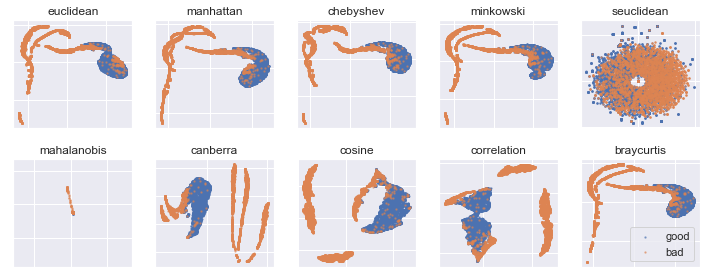

In [40]:
%%time

n_components = 2
tsne_sample_size = 10000
xx = X.head(tsne_sample_size)
# shouldn't this also be y.head(tsne_sample_size)???
yy = y[:tsne_sample_size]
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for ax, dist in zip(axs.ravel(), all_dist):
    tsne = umap.UMAP(metric=dist)
    zz = tsne.fit_transform(xx)
    ax.scatter(zz[yy == 1, 0], zz[yy == 1, 1], s=2, c='C0', alpha=0.5, label='good')
    ax.scatter(zz[yy == 0, 0], zz[yy == 0, 1], s=2, c='C1', alpha=0.5, label='bad')
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.set_title(dist)
fig.tight_layout()
ax.legend()

### Models

Train/test split

In [ ]:
train_test_split()

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0, random_state=random_seed)

In [35]:
y_test

Series([], Name: good, dtype: int64)

In [36]:
X_train.shape, y_train.shape

((600000, 7), (600000,))

In [37]:
X_test.shape, y_test.shape

((0, 7), (0,))

In [38]:
from sklearn.metrics import *
from sklearn.metrics.classification import *

def evaluate_preds(y_hat):
    return pd.Series({
        'precision': precision_score(y_test, y_hat), # true positives
        'recall': recall_score(y_test, y_hat), # of all good ones
        'f1': f1_score(y_test, y_hat),
        'accuracy': accuracy_score(y_test, y_hat),
        'roc_auc': roc_auc_score(y_test, y_hat)
    })

def evaluate(clf):
    y_hat = %time clf.predict(X_test)
    return evaluate_preds(y_hat)

def feature_importances(clf):
    pd.Series(dict(zip(X.columns, clf.feature_importances_))).sort_index().plot.bar()
    plt.show()

#### K Nearest Neighbors

In [39]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

CPU times: user 2.39 s, sys: 41.4 ms, total: 2.44 s
Wall time: 1.74 s


In [40]:
evaluate(knn)

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.

ValueError: Expected array-like (array or non-string sequence), got None

In [18]:
%time knn_bad = knn.predict(bad[feature_cols])
%time knn_good = knn.predict(good[feature_cols])

CPU times: user 5.63 s, sys: 80.7 ms, total: 5.71 s
Wall time: 4.91 s
CPU times: user 10.4 s, sys: 38.5 ms, total: 10.5 s
Wall time: 9.7 s


#### Random forest

In [19]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


CPU times: user 27.7 s, sys: 949 ms, total: 28.7 s
Wall time: 5.37 s


In [20]:
%time rf.predict(mixed_data[feature_cols]);

CPU times: user 13.4 s, sys: 2.36 s, total: 15.7 s
Wall time: 3.77 s


array([0, 0, 1, ..., 1, 1, 1])

In [21]:
mixed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6177320 entries, 3 to 9816139
Data columns (total 11 columns):
frame       int64
x0          float64
y0          float64
nphotons    float64
sigma_x     float64
sigma_y     float64
sigma_z     float64
z0          float64
offset      float64
amp         float64
chi2        float64
dtypes: float64(10), int64(1)
memory usage: 565.6 MB


In [22]:
evaluate(rf)

CPU times: user 231 ms, sys: 132 ms, total: 363 ms
Wall time: 219 ms


precision    0.982326
recall       0.990944
f1           0.986616
accuracy     0.986517
roc_auc      0.986503
dtype: float64

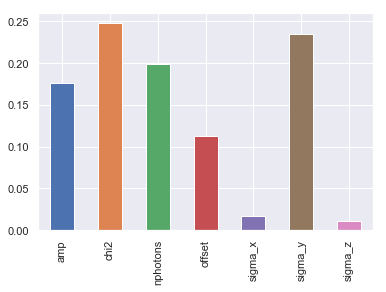

In [23]:
feature_importances(rf)

### Naive Bayes

In [159]:
%%time
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

Wall time: 184 ms


In [160]:
evaluate(nb)

Wall time: 53 ms


accuracy     0.958992
f1           0.959508
precision    0.946402
recall       0.972982
roc_auc      0.959009
dtype: float64

### XGBoost

In [161]:
%%time
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=5, n_estimators=100, nthread=16)
xgb.fit(X_train, y_train)

Wall time: 26.3 s


In [162]:
evaluate(xgb)

C:\Users\hoffmand\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Wall time: 410 ms


accuracy     0.986758
f1           0.986822
precision    0.980891
recall       0.992824
roc_auc      0.986766
dtype: float64

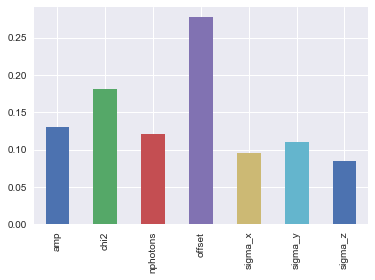

In [163]:
feature_importances(xgb)

#### Logistic regression

(This does amazingly well for a fast-to-train linear model.)

In [164]:
%%time
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(n_jobs=16)
lr.fit(X_train, y_train)

Wall time: 13.3 s


In [165]:
evaluate(lr)

Wall time: 4 ms


accuracy     0.972925
f1           0.973154
precision    0.963781
recall       0.982711
roc_auc      0.972937
dtype: float64

#### Big guns: TPOT

In [28]:
from tpot import TPOTClassifier

tp = TPOTClassifier(generations=5, max_time_mins=150, population_size=50, n_jobs=24, verbosity=2)
tp.fit(X_train, y_train)

306.49047171666666 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.



Best pipeline: ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=19, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=1000000, max_eval_time_mins=5,
        max_time_mins=150, memory=None, mutation_rate=0.9, n_jobs=24,
        offspring_size=50, periodic_checkpoint_folder=None,
        population_size=50, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

Turns out TPOT ended up with just a XGBoost classifier with a Robust Scaler for the inputs before they go in.

In [29]:
tp.export('tpot_pipeline_dph.py')

True

In [ ]:
# %load tpot_pipeline_dph.py
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot.builtins import ZeroCount

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)

# Score on the training set was:0.9860291666666667
exported_pipeline = make_pipeline(
    ZeroCount(),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=19, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [30]:
evaluate(tp)

Wall time: 2.71 s


accuracy     0.986508
f1           0.986558
precision    0.979201
recall       0.994027
roc_auc      0.986537
dtype: float64

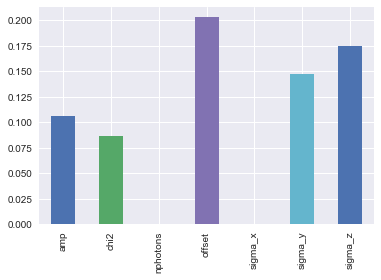

In [31]:
feature_importances(tp.fitted_pipeline_.steps[-1][1])

<hr>

## Voting classifier (ensemble of above)

In [32]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('rf', rf),
    ('lr', lr),
    ('knn', knn),
    ('nb', nb),
    ('xgb', tp),
]

predictions = (pd.DataFrame({name: model.predict(X_test) for name, model in estimators})
               .assign(vote_ratio=lambda x: x.sum(axis=1) / len(estimators))
               .assign(y_hat=lambda x: (x.vote_ratio > 0.5).astype(np.int)))

In [33]:
predictions.head(10)

,knn,lr,nb,rf,xgb,vote_ratio,y_hat
0,1,1,1,1,1,1.0,1
1,0,0,0,0,0,0.0,0
2,1,1,1,1,1,1.0,1
3,1,1,1,1,1,1.0,1
4,1,1,1,1,1,1.0,1
5,1,1,1,1,1,1.0,1
6,0,0,0,0,0,0.0,0
7,1,1,1,1,1,1.0,1
8,0,0,0,0,0,0.0,0
9,1,1,1,1,1,1.0,1


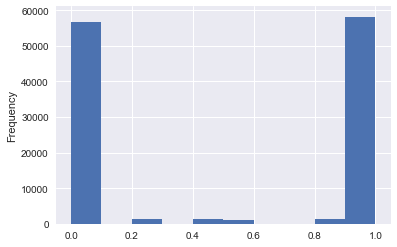

In [92]:
predictions.vote_ratio.plot.hist()

In [37]:
evaluate_preds(predictions.y_hat)

accuracy     0.985042
f1           0.985088
precision    0.978349
recall       0.991919
roc_auc      0.985068
dtype: float64